# ML Pipeline

## Data Preparation

In [413]:
import sys
sys.path.append('..')
from scripts.utils import initialize_bucket, plot_importance

from datetime import date

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, explained_variance_score,mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import shap

import pickle
import json




### Extracting refined dataset from Google Storage Bucket

In [414]:
pd.set_option("display.max_columns", 400)

credentials_path = '../datascience-capstone-project-05b1642f45c3.json'

In [415]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/03_refined/df_windowed_full.parquet"
base_dataset =  pd.read_parquet(path)

df = base_dataset.copy()

In [416]:
df[['Papel','Tipo','Setor','Subsetor']]

,Papel,Tipo,Setor,Subsetor
24,ABCB4,PN,Intermediários Financeiros,Bancos
25,ABCB4,PN,Intermediários Financeiros,Bancos
26,ABCB4,PN,Intermediários Financeiros,Bancos
27,ABCB4,PN,Intermediários Financeiros,Bancos
28,ABCB4,PN,Intermediários Financeiros,Bancos
...,...,...,...,...
91432,ORVR3,ON,Água e Saneamento,Água e Saneamento
91457,POWE3,ON,Energia Elétrica,Energia Elétrica
91458,POWE3,ON,Energia Elétrica,Energia Elétrica
91483,WEST3,ON,Programas e Serviços,Programas e Serviços


In [417]:
df = df[df.columns.sort_values()]

In [418]:
df.shape

(76852, 312)

In [419]:
[col for col in df.columns if 'category' in col]

['Lucro_Liquido_12m_category']

## Select Features

In [428]:
features = [
                'Empresa', 'Papel',
                'year_last', 'month_last',
                'besst_1', 'besst_2',
                'Setor','Tipo',
                'Lucro_Liquido_12m_category',
                # 'Valor_de_mercado_category',
                # 'Patrim_Liq_category',
                'dy_label',
                'dy_median_last', 'dy_median_max','dy_median_min','dy_spread','dy_mean_std','dy_mean_last', 'dy_median_ref_min',#add dy relativo
                'euro_last','euro_mean', #add euro relativo
                'evebit_mean_ref_mean','evebit_mean_last','evebit_mean_mean', #add evebit relativo
                'c5y_mean_last','c5y_mean_mean', #add c5y relativo
                'cotacao_max_ref_max','cotacao_mean_ref_mean','cotacao_mean_ref_std', 'cotacao_mean_last', 'cotacao_mean_mean',#add cotacao relativo
                'divbpatr_max_ref_max','divbpatr_mean_last','divbpatr_mean_mean', #add divbpatr relativo
                'dolar_comercial_last','dolar_comercial_mean', #add euro relativo
                'ibovespa_spread','ibovespa_spread_relevance','ibovespa_last','ibovespa_mean',#add ibovespa relativo
                'pib_dolarizado_last','pib_dolarizado_mean', #add pib_dolarizado relativo
                'preco_do_petroleo_last','preco_do_petroleo_mean', #add preco_do_petroleo relativo
                'igpm_last','igpm_mean',#add igpm relativo
                'ipca_last','ipca_mean',#add ipca relativo
                'selic_last','selic_mean',#add igpm relativo
                'liq2m_mean_ref_mean','liq2m_mean_last','liq2m_mean_mean', #add liq2m relativo
                'liqc_mean_ref_mean','liqc_mean_last','liqc_mean_mean', #add liqc relativo
                'mrgebit_mean_ref_mean','mrgebit_mean_last','mrgebit_mean_mean', #add mrgebit relativo
                'mrgliq_mean_ref_mean','mrgliq_mean_last','mrgliq_mean_mean', #add mrgliq relativo
                'pa_mean_ref_mean','pa_mean_last', 'pa_mean_mean',#add pa relativo
                'pl_mean_ref_mean','pl_mean_last', 'pl_mean_mean',#add pa relativo
                'pcg_mean_ref_mean','pcg_mean_last', 'pcg_mean_mean',#add pcg relativo
                'pebit_mean_ref_mean','pebit_mean_last', 'pebit_mean_mean',#add pebit relativo
                'pacl_mean_ref_mean','pacl_mean_last', 'pacl_mean_mean',#add pacl relativo
                'psr_mean_ref_mean','psr_mean_last', 'psr_mean_mean',#add psr relativo
                'pvp_mean_ref_mean','pvp_mean_last', 'pvp_mean_mean',#add pvp relativo
                'roe_mean_ref_mean','roe_mean_last', 'roe_mean_mean',#add roe relativo
                'roic_mean_ref_mean','roic_mean_last', 'roic_mean_mean',#add roic relativo
                'patrliq_mean_ref_mean','patrliq_mean_last','patrliq_mean_mean', #add patrliq relativo
            ]

roots = [
            'euro',
            'dy_mean',
            'evebit_mean',
            'c5y_mean',
            'cotacao_mean',
            'divbpatr_mean',
            'dolar_comercial',
            'ibovespa',
            'pib_dolarizado',
            'preco_do_petroleo',
            'igpm',
            'ipca',
            'selic',
            'liq2m',
            'liqc',
            'mrgebit',
            'mrgliq',
            'pa_mean',
            'pl_mean',
            'pcg_mean',
            'pebit_mean',
            'pacl_mean',
            'psr_mean',
            'pvp_mean',
            'roe_mean',
            'roic_mean_last',
            'patrliq_mean'
        ]

setor_encoding = {
    'Computadores e Equipamentos':1,
    'Tecidos, Vestuário e Calçados':2,
    'Máquinas e Equipamentos':3,
    'Equipamentos':4,
    'Automóveis e Motocicletas':5,
    'Bebidas':6,
    'Alimentos Processados':7,
    'Produtos de Uso Pessoal e de Limpeza':8,
    'Utilidades Domésticas':9,
    'Embalagens':10,
    'Materiais Diversos':11,
    'Medicamentos e Outros Produtos':12,
    'Serv.Méd.Hospit. Análises e Diagnósticos':13,
    'Hoteis e Restaurantes':14,
    'Viagens e Lazer':15,
    'Transporte':16,
    'Material de Transporte':17,
    'Serviços Diversos':18,
    'Programas e Serviços':19,
    'Comércio e Distribuição':20,
    'Comércio':21,
    'Telecomunicações':22,
    'Mídia':23,
    'Holdings Diversificadas':24,
    'Serviços Financeiros Diversos':25,
    'Intermediários Financeiros':26,
    'Previdência e Seguros':27,
    'Exploração de Imóveis':28,
    'Químicos':29,
    'Construção e Engenharia':30,
    'Construção Civil':31,
    'Siderurgia e Metalurgia':32,
    'Energia Elétrica':33,
    'Água e Saneamento':34,
    'Gás':35,
    'Petróleo, Gás e Biocombustíveis':36,
    'Mineração':37,
    'Madeira e Papel':38,
    'Agropecuária':39,
    'Diversos':40,
    'Outros':41,
}

In [429]:
df['dy_mean_std'].min()

9.273840273963735e-06

In [430]:
df['dy_mean_std'][((df['dy_mean_std']<=0.005)&(df['dy_median_min']<=0.005))]

Series([], Name: dy_mean_std, dtype: float64)

In [431]:
df['dy_mean_std'][((df['dy_mean_std']<=0.005)&(df['dy_median_min']<=0.005))] = df['dy_mean_std'].max()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [432]:
df = df[features]

df['encoded_sectors']    = df['Setor'].replace(setor_encoding)

df['power_valuation']    = df['roe_mean_last']*df['roic_mean_last']*df['roe_mean_mean']*df['roe_mean_mean']
df['power_price']        = df['pvp_mean_last']*df['psr_mean_last']*df['pacl_mean_last']*df['pl_mean_last']*df['pa_mean_last']
df['power_price']        = (df['pl_mean_last']*df['pa_mean_last'])/(df['pl_mean_ref_mean']*df['pa_mean_ref_mean'])
df['power_margin']       = df['mrgliq_mean_last']/1_000_000*df['mrgebit_mean_last']/1_000_000
df['power_buy_flag']     = (df['pl_mean_last']*df['dy_median_last']*df['dy_median_min'])
df['power_stabil']       = df['dy_median_min']/df['dy_mean_std']
df['power_stabil_delta'] = (df['dy_median_max'] - df['dy_median_min'])/df['dy_mean_std']
df['power_min']          = df['dy_median_min']*df['dy_median_ref_min']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [433]:
def create_trends(data,roots):
    
    data_out = data.copy()
    for root in roots:
        try:
            data_out[root + '_trend'] = (np.divide(data_out[root + '_last'],data_out[root + '_mean'])-1)*100
        except:
            continue
    return data_out



df = create_trends(df,roots)

In [434]:
df[df.columns[df.dtypes=='float64']].max().sort_values(ascending=False)[:50].index

Index(['liq2m_mean_ref_mean', 'patrliq_mean_ref_mean', 'patrliq_mean_mean',
       'patrliq_mean_last', 'power_valuation', 'liq2m_mean_last',
       'liq2m_mean_mean', 'pl_mean_ref_mean', 'evebit_mean_last',
       'pl_mean_last', 'pebit_mean_last', 'evebit_mean_mean', 'pl_mean_mean',
       'pebit_mean_mean', 'patrliq_mean_trend', 'psr_mean_ref_mean',
       'pebit_mean_ref_mean', 'pl_mean_trend', 'evebit_mean_ref_mean',
       'pcg_mean_ref_mean', 'psr_mean_trend', 'pcg_mean_last', 'power_min',
       'pebit_mean_trend', 'pcg_mean_trend', 'pcg_mean_mean',
       'pacl_mean_trend', 'pvp_mean_trend', 'power_price',
       'mrgebit_mean_ref_mean', 'psr_mean_last', 'evebit_mean_trend',
       'divbpatr_mean_trend', 'psr_mean_mean', 'pacl_mean_ref_mean',
       'pacl_mean_last', 'ibovespa_spread', 'ibovespa_mean', 'ibovespa_last',
       'pa_mean_trend', 'mrgliq_mean_ref_mean', 'roe_mean_ref_mean',
       'pvp_mean_last', 'pacl_mean_mean', 'roic_mean_ref_mean',
       'pvp_mean_mean', 'ro

In [435]:
def transform_dummy(data, features):
    """
    Transform categorical values into numerical values using one-hot encoding.
    
    Parameters:
        data (DataFrame): The DataFrame containing the categorical features to be transformed.
        features (list): List of categorical features to be transformed.
        
    Returns:
        DataFrame: The transformed DataFrame with numerical values for categorical features.
    """
    for feature in features:
        # Generate one-hot encoded columns and append to the DataFrame
        one_hot_encoded = pd.get_dummies(data[feature])
        new_columns = [(str(feature) + '_' + str(col)) for col in one_hot_encoded.columns]
        data[new_columns] = one_hot_encoded
        
        # Drop the original categorical feature from the DataFrame
        data.drop(feature, axis=1, inplace=True)
        
    return data

In [436]:
def column_name_cleaner(col):
    """
    Clean column names by replacing non-UTF-8 characters with a replacement character.

    Parameters:
        col (str): The column name to be cleaned.

    Returns:
        str: The cleaned column name.
    """
    return col.encode('utf-8', 'replace').decode('utf-8')


In [437]:
def create_year_month_column(data: pd.DataFrame, year_column: str, month_column: str) -> pd.DataFrame:
    """
    Create a new column 'year_month' in the DataFrame by concatenating values from two columns.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the columns 'year_last' and 'month_last'.
        year_column (str): Name of the column containing the year values.
        month_column (str): Name of the column containing the month values.

    Returns:
        pd.DataFrame: The DataFrame with a new 'year_month' column.
    """
    # Ensure that the specified columns exist in the DataFrame
    if year_column not in data.columns or month_column not in data.columns:
        raise ValueError(f"Columns '{year_column}' and '{month_column}' not found in the DataFrame.")
    
    # Create the 'year_month' column by concatenating the values from 'year_last' and 'month_last' columns
    data['year_month'] = data[year_column].astype(str) + data[month_column].astype(str)
    
    return data

In [438]:
df.columns = [column_name_cleaner(col) for col in df.columns]

df = create_year_month_column(df, 'year_last', 'month_last')


In [439]:
object_cols = df.columns[df.dtypes == 'object'] 
print(object_cols)

Index(['Empresa', 'Papel', 'Setor', 'Tipo', 'year_month'], dtype='object')


In [440]:
bool_cols = df.columns[df.dtypes == 'bool'] 
print(bool_cols)

Index(['besst_1', 'besst_2'], dtype='object')


In [441]:
df.columns[df.dtypes=='float64'][(df[df.columns[df.dtypes=='float64']].max()>1_000_000_000_000)]

Index(['liq2m_mean_ref_mean', 'patrliq_mean_ref_mean'], dtype='object')

In [442]:
# dropping columns with maximum values larger than 1 trillion dollars
to_drop = df.columns[df.dtypes=='float64'][(df[df.columns[df.dtypes=='float64']].max()>1_000_000_000_000)]
# df = df.drop(to_drop, axis=1)

In [443]:
df[to_drop].max()

liq2m_mean_ref_mean      8.697993e+38
patrliq_mean_ref_mean    1.410626e+12
dtype: float64

In [444]:
# transforming bool_cols to float
df[bool_cols] = df[bool_cols].astype('float64')

In [445]:
# checking NaN values and inputing median
df.isna().mean().sort_values(ascending=False)[:30]

divbpatr_mean_trend    0.135221
psr_mean_trend         0.110355
pacl_mean_trend        0.105345
pcg_mean_trend         0.105345
evebit_mean_trend      0.103498
pebit_mean_trend       0.101663
power_price            0.101663
pa_mean_trend          0.096068
c5y_mean_trend         0.016083
roe_mean_trend         0.005595
pl_mean_trend          0.005595
psr_mean_mean          0.000000
pacl_mean_mean         0.000000
psr_mean_ref_mean      0.000000
psr_mean_last          0.000000
Empresa                0.000000
pvp_mean_ref_mean      0.000000
pvp_mean_last          0.000000
pacl_mean_last         0.000000
roe_mean_ref_mean      0.000000
roe_mean_last          0.000000
pvp_mean_mean          0.000000
pebit_mean_last        0.000000
pacl_mean_ref_mean     0.000000
pebit_mean_mean        0.000000
roic_mean_ref_mean     0.000000
pebit_mean_ref_mean    0.000000
pcg_mean_mean          0.000000
pcg_mean_last          0.000000
pcg_mean_ref_mean      0.000000
dtype: float64

In [446]:
# inpute 0 for missing values
df.fillna(0, inplace=True)

In [447]:
df = transform_dummy(df,['Tipo'])

In [448]:
cor = df.corr()['dy_label']

<AxesSubplot:>

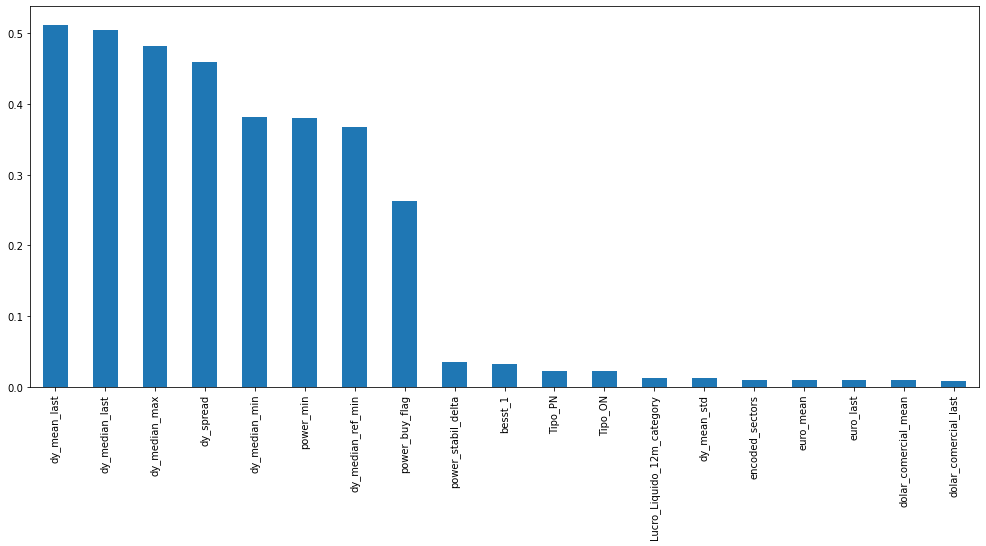

In [449]:
plt.figure(figsize=(17,7))
np.abs(cor).sort_values(ascending=False)[1:20].plot(kind='bar')

In [450]:
training_cols = np.abs(cor).sort_values(ascending=False)[0:150].index

In [451]:
df_to_train = df[['Empresa', 'Papel', 'year_month'] + list(training_cols)].copy()

In [452]:
df_to_train.sort_values(by='year_month', ascending=False)

,Empresa,Papel,year_month,dy_label,dy_mean_last,dy_median_last,dy_median_max,dy_spread,dy_median_min,power_min,dy_median_ref_min,power_buy_flag,power_stabil_delta,besst_1,Tipo_PN,Tipo_ON,Lucro_Liquido_12m_category,dy_mean_std,encoded_sectors,euro_mean,euro_last,dolar_comercial_mean,dolar_comercial_last,power_stabil,year_last,cotacao_mean_mean,dolar_comercial_trend,patrliq_mean_mean,patrliq_mean_last,selic_trend,cotacao_mean_ref_mean,liq2m_mean_mean,besst_2,liq2m_mean_last,liqc_mean_mean,cotacao_max_ref_max,selic_last,ibovespa_spread_relevance,ibovespa_spread,liqc_mean_last,ipca_mean,pib_dolarizado_mean,preco_do_petroleo_mean,ibovespa_mean,igpm_mean,pib_dolarizado_trend,ibovespa_trend,igpm_trend,ipca_trend,preco_do_petroleo_trend,cotacao_mean_last,divbpatr_mean_mean,c5y_mean_mean,cotacao_mean_ref_std,divbpatr_max_ref_max,divbpatr_mean_last,c5y_mean_last,liqc_mean_ref_mean,mrgebit_mean_mean,pvp_mean_ref_mean,mrgebit_mean_last,euro_trend,mrgliq_mean_ref_mean,mrgliq_mean_mean,patrliq_mean_ref_mean,roe_mean_trend,roe_mean_ref_mean,mrgebit_mean_ref_mean,mrgliq_mean_last,month_last,pcg_mean_ref_mean,pvp_mean_trend,liq2m_mean_ref_mean,pa_mean_mean,roic_mean_mean,pl_mean_mean,pebit_mean_mean,evebit_mean_mean,pl_mean_ref_mean,pa_mean_last,pl_mean_last,pebit_mean_last,evebit_mean_last,psr_mean_mean,pacl_mean_ref_mean,roe_mean_mean,roic_mean_last,pebit_mean_ref_mean,power_valuation,c5y_mean_trend,pvp_mean_mean,psr_mean_last,pa_mean_trend,pacl_mean_trend,pvp_mean_last,power_price,roic_mean_ref_mean,pebit_mean_trend,power_margin,patrliq_mean_trend,psr_mean_ref_mean,pcg_mean_last,pa_mean_ref_mean,pacl_mean_mean,roe_mean_last,pl_mean_trend,pcg_mean_trend,psr_mean_trend,pcg_mean_mean,evebit_mean_trend,pacl_mean_last,evebit_mean_ref_mean,divbpatr_mean_trend,selic_mean,cotacao_mean_trend,ibovespa_last,pib_dolarizado_last,preco_do_petroleo_last,igpm_last,ipca_last
91484,WESTWING ON NM,WEST3,2022.04.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,1,1.0,312.472845,19,4.469975,5.18520,4.318067,4.9191,0.000000,2022.0,1.625112,13.919038,3.597245e+08,3.892676e+08,4.791472,0.219928,7.359318e+05,0.0,1.698111e+06,5.888733,0.322738,0.043739,1.0,240413.5,5.716428,0.70,1287.416667,0.766667,200344.583333,-0.05,2.000000e+01,20.0,20.0,20.0,20.0,3.003097,-0.086687,-0.062435,0.034345,1.746359,-0.202417,-0.442662,2.069110,-0.178697,0.403122,-0.077956,16.000649,-7.299304,-0.107849,0.546184,16.635136,-79.948311,-4.149751,-0.032764,4.0,0.377255,-36.912817,4.375555e-01,0.431999,-0.231794,2.407749,-0.946021,0.135027,-0.065563,0.052368,9.079007,-2.893832,-0.115432,0.263238,0.522847,-0.242796,-0.166104,-2.247735e-01,2.772916e-03,608.999124,0.544341,0.631789,-87.877789,26.109114,0.343409,-14.165068,-7.602229,205.895213,2.554168e-15,8.212693e+00,0.137758,1.084162,0.511945,0.938978,-0.283186,277.074540,34.279580,140.006267,0.807392,-185.487856,1.184137,2.606193e-02,133.504786,0.041739,8.479320e+01,240413.5,1544.9,0.92,-0.06,0.84
56359,PETTENATI PN,PTNT4,2022.04.0,0.045183,0.047450,0.047450,0.050134,0.028300,0.047664,0.000000,0.000000,0.007815,2.513153,0.0,1,0,4.0,0.000983,2,4.469975,5.18520,4.318067,4.9191,48.492620,2022.0,8.319210,13.919038,3.450790e+08,3.449088e+08,4.791472,1.081593,1.571339e+05,0.0,7.695967e+04,1.623627,1.258281,0.043739,1.0,240413.5,1.568800,0.70,1287.416667,0.766667,200344.583333,-0.05,2.000000e+01,20.0,20.0,20.0,20.0,7.385145,0.236378,0.095977,0.141188,5.538462,0.319791,0.097367,1.475820,0.108485,2.102448,0.100382,16.000649,1.522462,0.098520,2.238235,-7.160984,1.584970,1.920076,0.093331,4.0,82.977550,-5.579615,2.305853e+07,0.531606,0.147608,4.155658,4.574757,6.822321,301.970843,0.495076,3.455463,4.387198,6.821242,0.463345,309.287080,0.189760,0.136853,1.744284e+00,8.681565e-04,1.447648,1.250423,0.436138,-6.871560,320.727520,1.180654,0.005578,3.068116,-4.099872,9.368815e-15,-4.930467e-02,0.947168,2.090130,1.015628,-25.045628,0.176171,-16.849198,35.338843,-5.871709,1.544368,-0.015813,-105.373848,8.682822e

In [453]:
df_to_pred  = df_to_train[df_to_train['year_month']=='2022.04.0'].copy()
df = df_to_train[df_to_train['year_month']!='2022.04.0']

In [454]:
df['dy_label']

24       0.081976
25       0.081300
26       0.080631
27       0.079991
28       0.079338
           ...   
91379    0.000000
91405    0.000000
91431    0.000000
91457    0.000000
91483    0.000000
Name: dy_label, Length: 76247, dtype: float64

In [455]:
df.isna().mean()

Empresa                   0.0
Papel                     0.0
year_month                0.0
dy_label                  0.0
dy_mean_last              0.0
                         ... 
ibovespa_last             0.0
pib_dolarizado_last       0.0
preco_do_petroleo_last    0.0
igpm_last                 0.0
ipca_last                 0.0
Length: 120, dtype: float64

#### Spliting data into training a test data

features X_train: 116
features X_test: 116



5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Pontello\anaconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\Pontello\anaconda3\lib\site-packages\xgboost\sklearn.py", line 988, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "c:\Users\Pontello\anaconda3\lib\site-packages\xgboost\sklearn.py", line 448, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(


R2 score: nan
Mean squared error: nan
test score: 0.4405176813855648 
train score: 0.9998446717760584


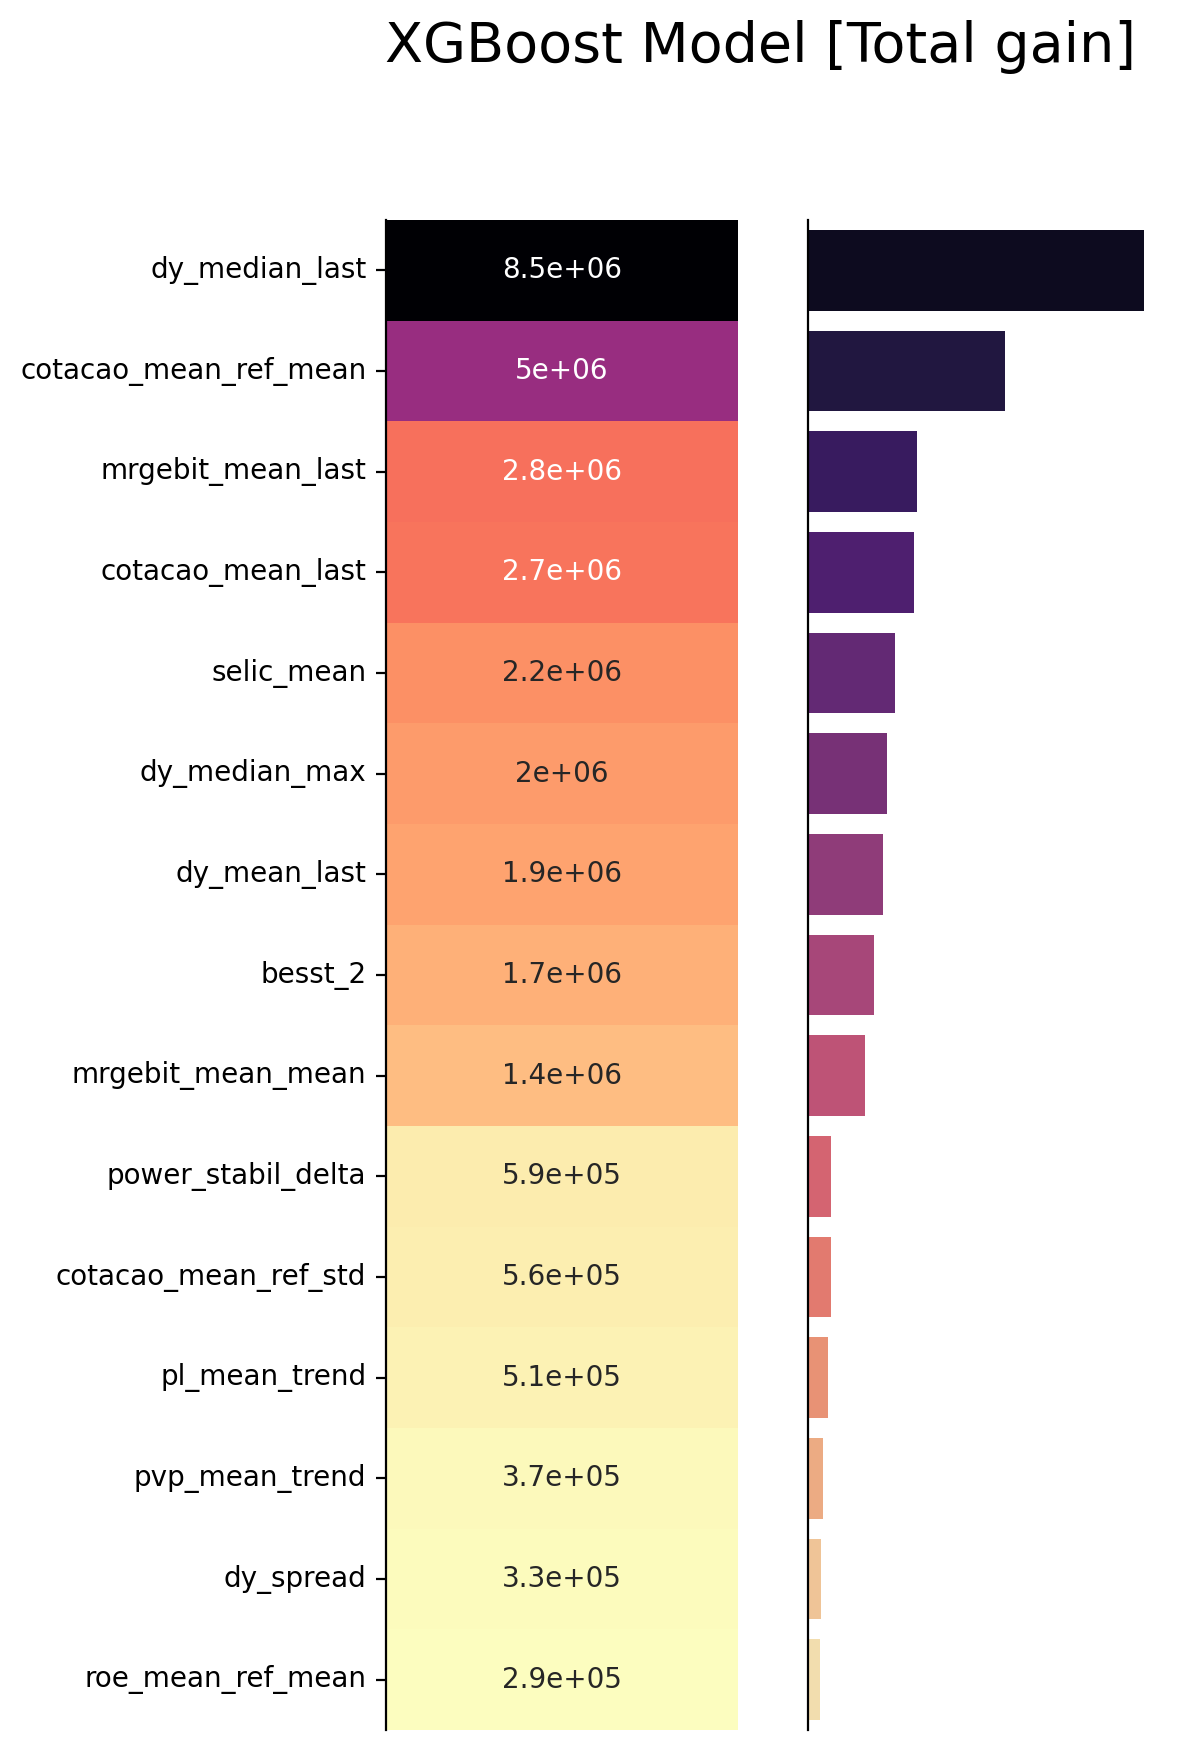

In [226]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()

# separating the train and target features
X = df.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
# X = df[training_features.index]
y = df['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# define the XGBoost model with your preferred hyperparameters
xgb_model = XGBRegressor()

# define the cross-validation method (e.g. KFold with 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define the evaluation metrics (r2 score and mean squared error)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# perform cross-validation and get the scores
scores = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)
xgb_model.fit(X_train, y_train)
xgb_model_pred_train=xgb_model.predict(X_train)
xgb_model_pred_test=xgb_model.predict(X_test)

print('R2 score:', np.mean(scores['test_r2']))
print('Mean squared error:', np.mean(scores['test_mse']))

# # define your cross validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # evaluate the XGBoost model with cross validation
# xgscore = cross_val_score(xgb_model, X, y, cv=cv, scoring=['neg_mean_squared_error','r2_score'])

# # print the mean and standard deviation of the cross validation scores
# print('Cross Validation Scores:')
# print('Mean:', np.mean(xgscore))
# print('Std:', np.std(xgscore))

# printing cross validation results
# print(f'XGBoost cross val score: {scoring}')

# # analysing train and test data results
train_score_xgb_model =  r2_score(y_train, xgb_model_pred_train)
test_score_xgb_model = r2_score(y_test, xgb_model_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgb_model} \ntrain score: {train_score_xgb_model}')

# getting the most important features
dict_importance = xgb_model.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

most_important = most_important_XGBoost_review

### Building a Machine Learning Pipeline 

In [227]:
def build_pipelines(regressors, transformers):
    pipelines = {}

    for transformer in transformers:
        for algorithm,regressor in regressors.items():
            pipeline = Pipeline([
                ('preprocessing', transformer),
                ('reg',regressor)
            ])
            pipelines[algorithm + '_' + str(transformer)] = pipeline

    return pipelines

In [228]:

def build_models(regressors,parameters_dict, transformers):
    pipelines = build_pipelines(regressors, transformers)

    cvs = {}
    
    for transformer in transformers:
        for algorithm,parameters in parameters_dict.items():
            # create grid search object
            cv = GridSearchCV(pipelines[algorithm + '_' + str(transformer)], cv=5, param_grid=parameters, scoring='r2')
            cvs[algorithm + '_' + str(transformer)] = cv

    print(cvs)
    
    return cvs

In [229]:
def display_and_store_results(X, y, y_test, y_pred, model, algorithm, sufix):

    # define the cross-validation method (e.g. KFold with 5 folds)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # define the evaluation metrics (r2 score and mean squared error)
    scoring = {'r2': make_scorer(r2_score), 
               'mse': make_scorer(mean_squared_error),
               'xve': make_scorer(explained_variance_score),
               'MAPE': make_scorer(mean_absolute_percentage_error)}
    # perform cross-validation and get the scores
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    print(scores)
    scores['fit_time']  = scores['fit_time'].tolist() 
    scores['score_time']= scores['score_time'].tolist() 
    scores['test_r2']   = scores['test_r2'].tolist() 
    scores['test_mse']  = scores['test_mse'].tolist()
    scores['test_xve']  = scores['test_xve'].tolist()
    scores['test_MAPE'] = scores['test_MAPE'].tolist()

    print('CV R2 score:', np.mean(scores['test_r2']))
    print('CV MSE:', np.mean(scores['test_mse']))

    performance = {}

    test_score_r2 = r2_score(y_test, y_pred)
    test_score_mse = mean_squared_error(y_test, y_pred)
    test_score_xvs = explained_variance_score(y_test, y_pred)
    test_score_mape = mean_absolute_percentage_error(y_test, y_pred)

    print('test r2:', test_score_r2)
    print('test mse:', test_score_mse)
    print('test explained_variance_score:', test_score_xvs)
    print('test MAPE:', test_score_mape)

    performance['cv_scores'] = scores
    performance['test_scores'] = {}
    performance['test_scores']['r2'] = test_score_r2
    performance['test_scores']['mse'] = test_score_mse
    performance['test_scores']['explained_variance_score'] = test_score_xvs
    performance['test_scores']['MAPE'] = test_score_mape
    
    print('___________________________________')
        
    print("\nBest Parameters:", model.best_params_)
    print('##################################')

    performance = {
        'algorithm':algorithm,
        'best_params':model.best_params_,
        'performance':performance,
        'features':X.columns.to_list()
    }

    patch = '../data/03_models/out/'
    filename = patch + f'{str(date.today())}_{algorithm}'

    # return performance
    if sufix != '':
        sufix_ = '_' + sufix
    else:
        sufix_ = sufix

    json.dump(performance, open(filename+f'_results{sufix_}.json', 'w'))   
    pickle.dump(model.best_estimator_, open(filename+f'{sufix_}.pkl', 'wb'))

    return test_score_r2



def train_models(df, params_path, label, regressors, transformers, cols_to_drop=None, cols_to_train=None, sufix=""):

    # separating the train and target features
    if cols_to_train == None:
        X = df.drop(cols_to_drop, axis=1)
    elif cols_to_train != None:
        print('here we go again')
        X = df[cols_to_train]
    else:
        raise

    y = df[label]

    with open(params_path) as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in parameters.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

    models = build_models(regressors,parameters,transformers)

    for algorithm, model in models.items():
        # X, y = load_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

        print(algorithm)        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = display_and_store_results(X, y, y_test, y_pred, model, algorithm, sufix)
        print(algorithm, r2)

    return models


In [230]:
params_path = '../data/03_models/in/params.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer()]

models = train_models(df, params_path, label, regressors, transformers, cols_to_drop)

{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.1, 0.01],
                         'reg__n_estimators': [100, 500],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2'), 'XGBRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsampl

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([39.16390729, 39.10687923, 38.95184422, 39.3999455 , 38.08964729]), 'score_time': array([0.04701066, 0.04801059, 0.04501009, 0.04601145, 0.04601049]), 'test_r2': array([0.5860742 , 0.43102302, 0.38398112, 0.43263666, 0.49417431]), 'test_mse': array([ 91.47784953, 177.88424543, 324.57808864, 204.52769995,
        61.49914353]), 'test_xve': array([0.58608412, 0.43102885, 0.38407848, 0.43264468, 0.49451605]), 'test_MAPE': array([5.50745391e+14, 6.30902636e+14, 4.64267333e+14, 5.85913956e+14,
       6.97782457e+14])}
CV R2 score: 0.4655778608848153
CV MSE: 171.99340541721773
test r2: 0.7223303203254489
test mse: 85.87117092339192
test explained_variance_score: 0.7223305030434974
test MAPE: 477189786209967.4
___________________________________

Best Parameters: {'reg__learning_rate': 0.01, 'reg__n_estimators': 500, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.7223303203254489
XGBRegressor_Normalizer()
{'fi

In [461]:
def load_model(path, model_name):
    
    with open(path + model_name, 'rb') as file:
        model = pickle.load(file)

    loaded_model = None
    for step_name, step_model in model.named_steps.items():
        if isinstance(step_model, LGBMRegressor):
            loaded_model = step_model
            break
        elif isinstance(step_model, XGBRegressor):
            loaded_model = step_model
            break
        elif step_name == 'preprocessing':
            transformer = step_model

    return loaded_model, transformer

In [463]:
def make_predictions(path, model_name, results_file, X_to_pred):
    # model_name = '2023-08-04_LGBMRegressor_Normalizer()_feat_selection.pkl'
    with open(path + model_name, 'rb') as file:
        pipeline = pickle.load(file)

    with open(path + results_file, 'rb') as json_file:
        results = json.load(json_file)

    model, transformer = load_model(path, model_name)

    features = results['features']

    return pipeline.predict(X_to_pred[features]), pipeline, model, transformer, features

In [465]:
path = '../data/03_models/out/'
model_name = f'{date.today()}_LGBMRegressor_Normalizer().pkl'
results_file = f'{date.today()}_LGBMRegressor_Normalizer()_results.json'

df_to_pred['dy_pred_LN'], lgb_pipeline, lgb_model, lgb_model_transformer, lgb_model_features = make_predictions(path, model_name, results_file, X_to_pred)



model_name = f'{date.today()}_XGBRegressor_Normalizer().pkl'
model_name = f'{date.today()}_XGBRegressor_Normalizer().pkl'
results_file = f'{date.today()}_XGBRegressor_Normalizer()_results.json'

df_to_pred['dy_pred_XN'], xgb_pipeline, xgb_model, xgb_model_transformer, xgb_model_features = make_predictions(path, model_name, results_file, X_to_pred)


In [336]:
def get_feature_importances(model, model_class, features):
    if 'LGB' in model_class:
        feature_importances = model.booster_.feature_importance(importance_type='gain')
    elif 'XGB' in model_class:
        feature_importances = model.get_booster().get_score(importance_type='gain').values()
        
    # Create a dictionary to associate feature names with their importance scores
    feature_importance_dict = dict(zip(features, feature_importances))
    df_feature_importance = pd.DataFrame(feature_importance_dict, 
                                      index=['Total gain']).T.sort_values(by='Total gain', ascending=False)
    return df_feature_importance

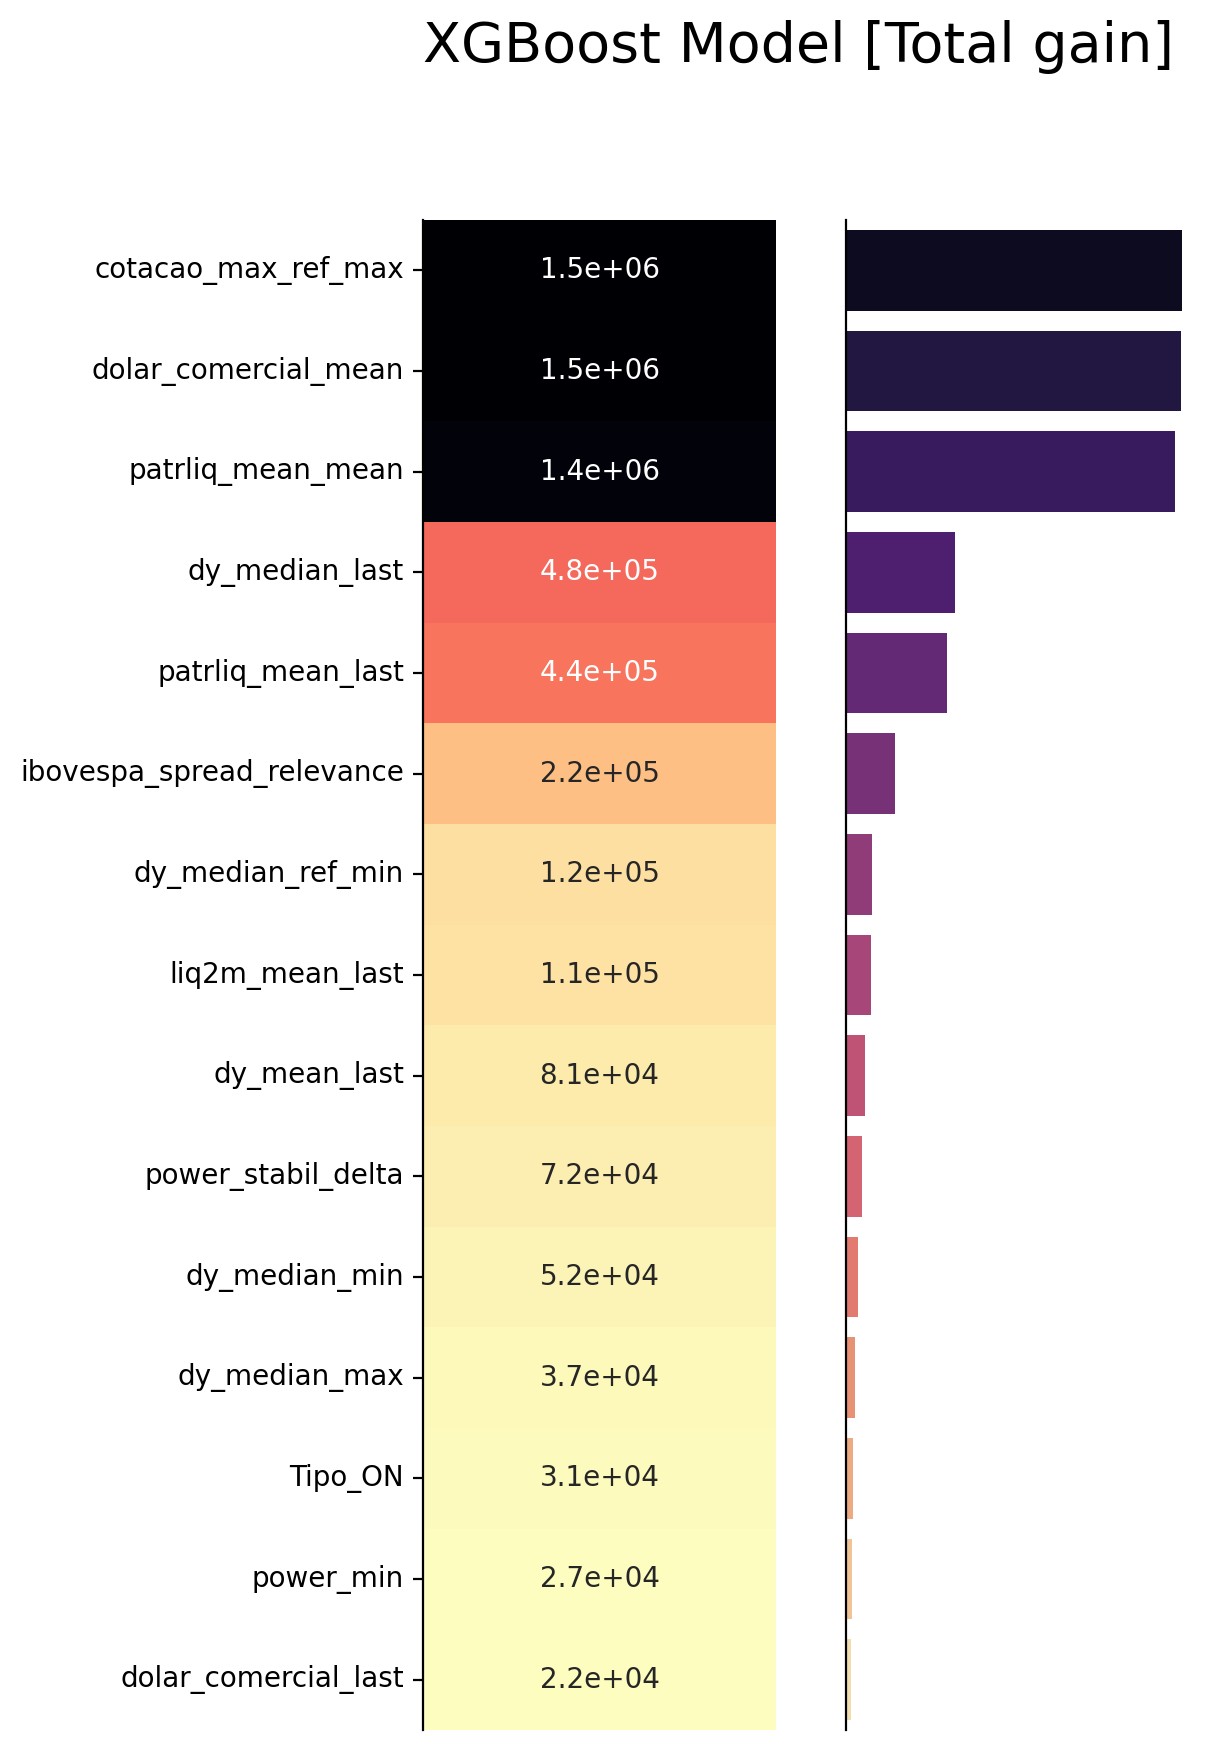

In [337]:
xgb_feature_importance = get_feature_importances(xgb_model, 'XGB', X.columns.to_list())
plot_importance(xgb_feature_importance, 'Total gain', 'XGBoost Model [Total gain]')

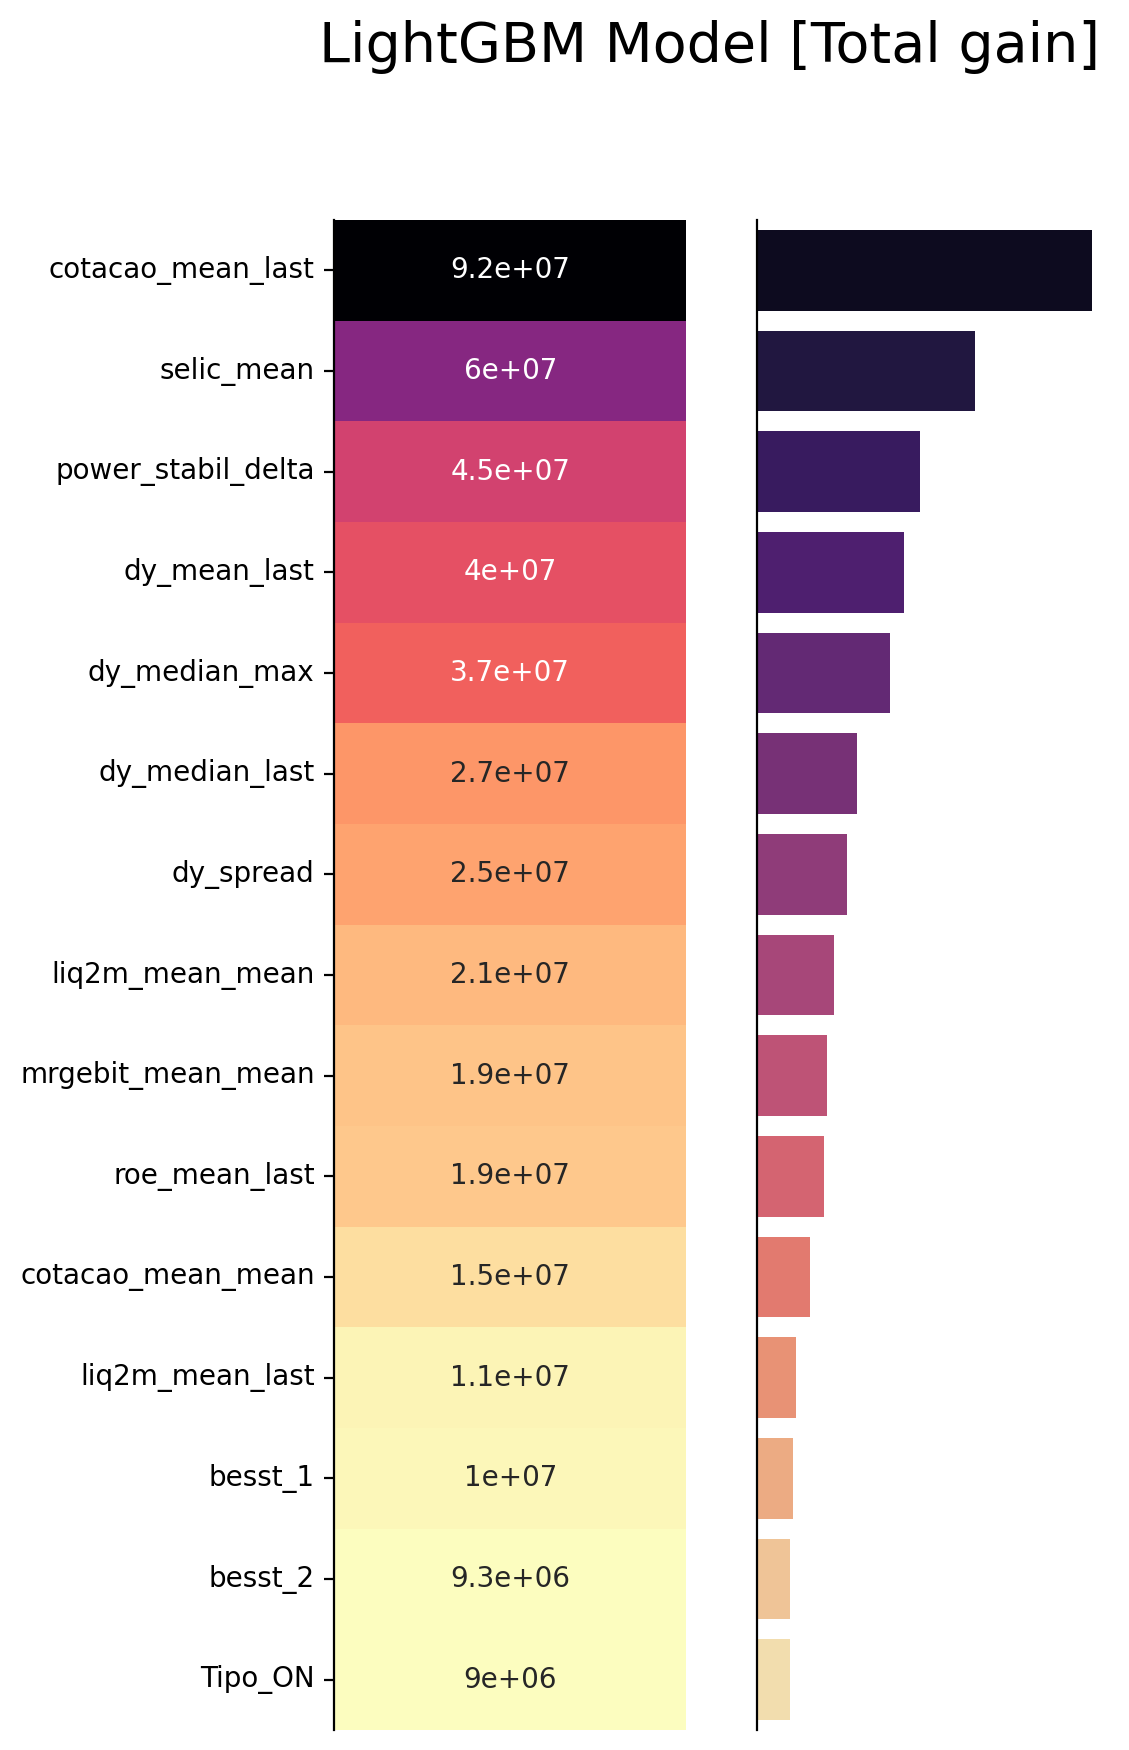

In [338]:
lgb_feature_importance = get_feature_importances(lgb_model, 'LGB', X.columns.to_list())
plot_importance(lgb_feature_importance, 'Total gain', 'LightGBM Model [Total gain]')

In [489]:
def calculate_shap_values(model, transformer, X_train, X_test, path, filename, plot=False):
    # If the LightGBM model is found, convert it to a LightGBM Booster object and prepare the explainer
    if model is not None:
        # Assuming you have your test data in 'X_test' (replace 'X_test' with your actual test data)
        explainer = shap.Explainer(model, transformer.transform(X_train))

        # Calculate SHAP values for the test data
        shap_values = explainer(transformer.transform(X_test), check_additivity=False)

        # Save SHAP values to a file using pickle
        with open(path + filename, 'wb') as file:
            pickle.dump(shap_values, file)

        # plot shap summary if desired
        if plot:
            shap.summary_plot(shap_values, X_test)
        
        # Return SHAP values
        return shap_values
    
    else:
        print("LightGBM model not found in the pipeline.")
    

In [472]:
# X = df.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
X = df[xgb_model_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

path = '../data/03_models/out/'

xgb_shap = calculate_shap_values(xgb_model, xgb_model_transformer, X_train, X_test)
file_name = f'{date.today()}_XGBRegressor_Normalizer()_SHAP.pkl'

# Save SHAP values to a file using pickle
with open(path + file_name, 'wb') as file:
    pickle.dump(xgb_shap, file)




X = df[lgb_model_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)


lgb_shap = calculate_shap_values(lgb_model, lgb_model_transformer, X_train, X_test)
file_name = f'{date.today()}_LGBMRegressor_Normalizer()_SHAP.pkl'

# Save SHAP values to a file using pickle
with open(path + file_name, 'wb') as file:
    pickle.dump(lgb_shap, file)

100%|===================| 22846/22875 [04:31<00:00]        

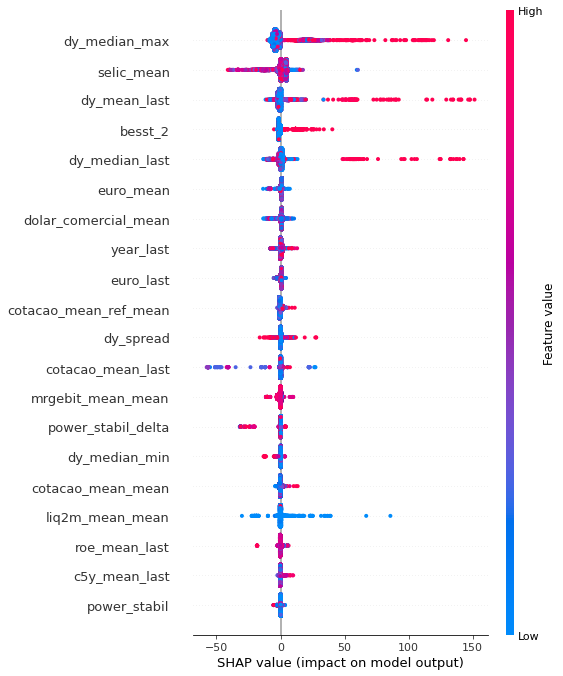

In [473]:
shap.summary_plot(lgb_shap, X_test)

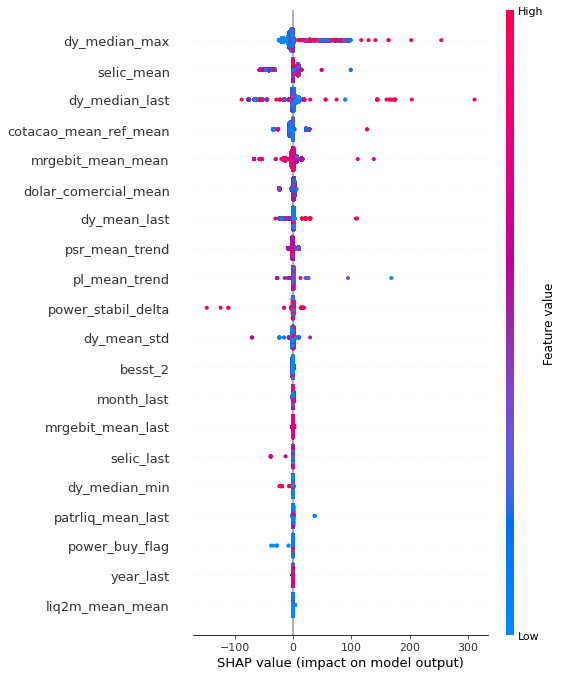

In [475]:
shap.summary_plot(xgb_shap, X_test)

In [479]:
xgb_shap.feature_names

In [480]:
d = dict(zip(xgb_model_features,np.abs(np.sum(xgb_shap.values, axis=0))))
df_xgb_shap = pd.DataFrame(d, index=['shap_values']).T.sort_values(by='shap_values', ascending=False)

d = dict(zip(lgb_model_features,np.abs(np.sum(lgb_shap.values, axis=0))))
df_lgb_shap = pd.DataFrame(d, index=['shap_values']).T.sort_values(by='shap_values', ascending=False)

In [481]:
n = 50

intersection_lgb_xgb = np.isin(df_lgb_shap.iloc[:n].index,df_xgb_shap.iloc[:n].index)
intersection_xgb_lgb = np.isin(df_xgb_shap.iloc[:n].index,df_lgb_shap.iloc[:n].index)
cols_to_train = df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index.to_list()

print('lgb in xgb ',np.mean(intersection_lgb_xgb))
print('xgb in lgb ',np.mean(intersection_xgb_lgb))
print('double check, cross intersection value', 
      np.isin(df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index,df_xgb_shap.iloc[:n].loc[intersection_xgb_lgb].index).mean())
print('\n\ncols to train:\n')
for col in  cols_to_train:
    print(col)

lgb in xgb  0.6
xgb in lgb  0.6
double check, cross intersection value 1.0


cols to train:

dy_median_max
besst_2
selic_mean
euro_mean
power_stabil_delta
dolar_comercial_mean
euro_last
dy_median_last
mrgebit_mean_mean
year_last
besst_1
dy_mean_last
cotacao_mean_ref_mean
power_buy_flag
pl_mean_trend
dy_spread
dy_median_min
pvp_mean_mean
cotacao_mean_mean
selic_last
cotacao_mean_last
dy_mean_std
psr_mean_last
liq2m_mean_ref_mean
pa_mean_trend
roic_mean_last
liq2m_mean_mean
pa_mean_last
pacl_mean_mean
roe_mean_mean


In [246]:
params_path = '../data/03_models/in/params_optimized.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer(),StandardScaler()]

models = train_models(df, params_path, label, regressors, transformers, cols_to_train=cols_to_train, sufix='feat_selection')

here we go again
{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.1],
                         'reg__max_depth': [3, 5, 7],
                         'reg__n_estimators': [500, 1000],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2'), 'XGBRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=N

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([35.1339643 , 35.36900401, 34.28882122, 36.30016208, 36.25415421]), 'score_time': array([0.05600953, 0.05300927, 0.05100846, 0.1060183 , 0.08601475]), 'test_r2': array([0.77743467, 0.57783225, 0.76517183, 0.77400306, 0.41230081]), 'test_mse': array([ 49.1870713 , 131.98599289, 123.73010319,  81.46919315,
        71.45346134]), 'test_xve': array([0.77745503, 0.57783245, 0.76518101, 0.77400478, 0.41237191]), 'test_MAPE': array([8.51530940e+14, 1.24070733e+15, 8.78483066e+14, 9.26932328e+14,
       1.00567815e+15])}
CV R2 score: 0.6613485245133711
CV MSE: 91.56516437405101
test r2: 0.653607276023346
test mse: 107.12422343729439
test explained_variance_score: 0.6536225305848749
test MAPE: 874685085713583.0
___________________________________

Best Parameters: {'reg__learning_rate': 0.1, 'reg__max_depth': 7, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.653607276023346
XGBRegresso

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([34.89139843, 35.33649325, 34.69735646, 35.28298855, 35.29748487]), 'score_time': array([0.03900838, 0.03900862, 0.06101298, 0.0990212 , 0.03900814]), 'test_r2': array([0.69843014, 0.59716532, 0.83440367, 0.75268157, 0.31704543]), 'test_mse': array([ 66.64712038, 125.94172594,  87.25209963,  89.15533588,
        83.03477159]), 'test_xve': array([0.69843075, 0.59717683, 0.83441394, 0.75268501, 0.31723135]), 'test_MAPE': array([7.42477510e+14, 8.04818073e+14, 6.59089037e+14, 7.30425938e+14,
       8.72506887e+14])}
CV R2 score: 0.6399452262470021
CV MSE: 90.40621068438422
test r2: 0.72526245647068
test mse: 84.96438857541318
test explained_variance_score: 0.72526690620325
test MAPE: 456200888970478.2
___________________________________

Best Parameters: {'reg__learning_rate': 0.1, 'reg__max_depth': 7, 'reg__n_estimators': 500, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_StandardScaler() 0.72526245647068
XGBRegressor_

### Train model with the most important features from the LightGBM and XGBoost models

In [249]:
n = 60

intersection_lgb_xgb = np.isin(df_lgb_shap.iloc[:n].index,df_xgb_shap.iloc[:n].index)
intersection_xgb_lgb = np.isin(df_xgb_shap.iloc[:n].index,df_lgb_shap.iloc[:n].index)
cols_to_train_lgmb = df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index.to_list()

print('lgb in xgb ',np.mean(intersection_lgb_xgb))
print('xgb in lgb ',np.mean(intersection_xgb_lgb))
print('double check, cross intersection value', 
      np.isin(df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index,df_xgb_shap.iloc[:n].loc[intersection_xgb_lgb].index).mean())
print('\n\ncols to train:\n')
for col in  cols_to_train_lgmb:
    print(col)

lgb in xgb  0.5833333333333334
xgb in lgb  0.5833333333333334
double check, cross intersection value 1.0


cols to train:

besst_1
dy_mean_last
roe_mean_last
liq2m_mean_mean
dolar_comercial_trend
power_stabil_delta
patrliq_mean_last
dy_median_max
dy_median_last
dy_median_min
psr_mean_mean
pvp_mean_trend
power_stabil
patrliq_mean_trend
roic_mean_mean
pebit_mean_ref_mean
pebit_mean_mean
roe_mean_trend
psr_mean_last
pib_dolarizado_trend
cotacao_mean_trend
roic_mean_last
power_buy_flag
pl_mean_trend
besst_2
pacl_mean_mean
pa_mean_ref_mean
roe_mean_mean
c5y_mean_trend
pl_mean_mean
power_valuation
evebit_mean_ref_mean
psr_mean_trend
pvp_mean_mean
pvp_mean_last


In [250]:
params_path = '../data/03_models/in/params_optimized_lgbm.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer(),StandardScaler()]

models = train_models(df, params_path, label, regressors, transformers, 
                        cols_to_drop=None, 
                        cols_to_train=cols_to_train_lgmb, 
                        sufix='feat_selection_lgbm')

here we go again
{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.01, 0.5],
                         'reg__max_depth': [3, 5],
                         'reg__n_estimators': [500, 1000],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2'), 'LGBMRegressor_StandardScaler()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.01, 0.5],
                         'reg__max_depth': [3, 5],
                         'reg__n_estimators': [500, 1000],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2')}
LGBMRegressor_Normalizer()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([52.63238811, 53.0639832 , 49.11809015, 50.79196525, 48.98357844]), 'score_time': array([0.04801106, 0.05401254, 0.06301427, 0.04701114, 0.04200935]), 'test_r2': array([0.6339342 , 0.31160608, 0.42648481, 0.57097003, 0.36358907]), 'test_mse': array([ 80.90076176, 215.21860583, 302.18304834, 154.66017561,
        77.37591715]), 'test_xve': array([0.63394267, 0.31160709, 0.4265564 , 0.57097028, 0.3637949 ]), 'test_MAPE': array([6.24532563e+14, 6.60531384e+14, 6.01566038e+14, 7.09770767e+14,
       9.59776825e+14])}
CV R2 score: 0.4613168379470215
CV MSE: 166.0677017365992
test r2: 0.5647969457665512
test mse: 134.5894009755212
test explained_variance_score: 0.5648228194322096
test MAPE: 1680184445663165.2
___________________________________

Best Parameters: {'reg__learning_rate': 0.5, 'reg__max_depth': 5, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.5647969457665512
LGBMRegre

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([49.39764786, 47.1786406 , 47.70626712, 48.39442158, 47.0461421 ]), 'score_time': array([0.03800845, 0.05401206, 0.03800893, 0.04301   , 0.03700829]), 'test_r2': array([0.69286778, 0.46884398, 0.53004514, 0.63872255, 0.30369682]), 'test_mse': array([ 67.87640517, 166.05994942, 247.61749217, 130.23620035,
        84.65771883]), 'test_xve': array([0.6928905 , 0.46885024, 0.53010831, 0.63872507, 0.30388794]), 'test_MAPE': array([5.10904947e+14, 5.01283165e+14, 4.99747462e+14, 5.25039406e+14,
       7.45190425e+14])}
CV R2 score: 0.5268352520725605
CV MSE: 139.28955318696444
test r2: 0.7424640309758105
test mse: 79.64468875722339
test explained_variance_score: 0.7424652283246757
test MAPE: 356177829035787.25
___________________________________

Best Parameters: {'reg__learning_rate': 0.01, 'reg__max_depth': 5, 'reg__n_estimators': 500, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_StandardScaler() 0.7424640309758105


In [251]:
# Comparar a distribuição de dividendos das empresas indicadas com o besst1 e com o total em quartis
# Plotar a distribuição de dividendos de algum dos primeiros do ranking
# entender alguns outliers

## Analyse the prediction outcomes for each model
### Best models (Transformer + Algorithm + Feature Selection)

In [316]:
def make_predictions(path, model_name, results_file, X_to_pred):
    # model_name = '2023-08-04_LGBMRegressor_Normalizer()_feat_selection.pkl'
    with open(path + model_name, 'rb') as file:
        pipeline = pickle.load(file)

    with open(path + results_file, 'rb') as json_file:
        results = json.load(json_file)

    features = results['features']

    return pipeline.predict(X_to_pred[features]), pipeline, model, features

In [253]:
[col for col in df_to_pred.columns if 'power' in col]

['power_min',
 'power_buy_flag',
 'power_stabil_delta',
 'power_stabil',
 'power_valuation',
 'power_price',
 'power_margin']

In [254]:
# separating the train and target features
X_to_pred = df_to_pred.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
y_to_pred = df_to_pred['dy_label']

100%|===================| 22850/22875 [09:19<00:00]        

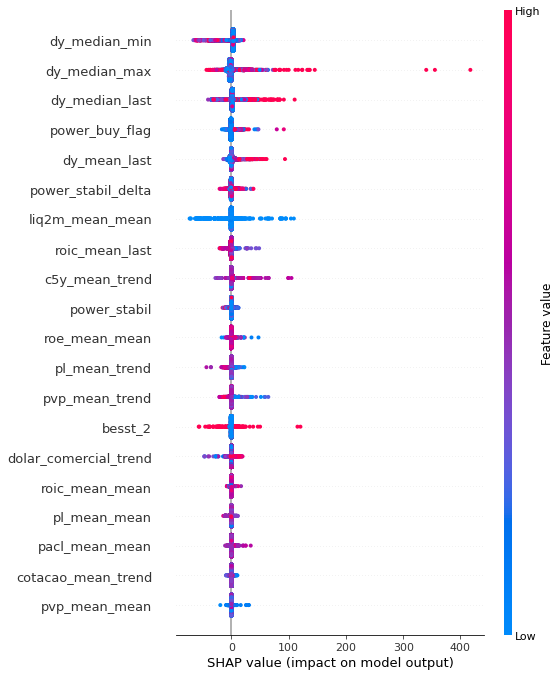

100%|===================| 22856/22875 [03:01<00:00]        

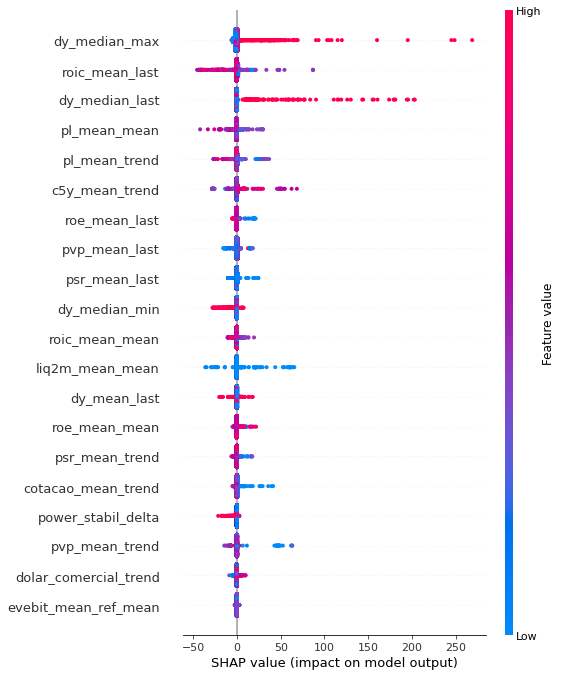

In [493]:
path = '../data/03_models/out/'

# '2023-08-07_LGBMRegressor_Normalizer()_feat_selection.pkl'

model_name = '2023-08-07_LGBMRegressor_Normalizer()_feat_selection.pkl'
results_file = '2023-08-07_LGBMRegressor_Normalizer()_results_feat_selection.json'
file_name_SHAP = '2023-08-07_LGBMRegressor_Normalizer()_results_feat_selection_SHAP.pkl'

df_to_pred['dy_pred_N_FS'], N_FS_0807_pipeline, N_FS_0807_model, N_FS_0807_transformer, N_FS_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[N_FS_0807_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

N_FS_0807_shap = calculate_shap_values(N_FS_0807_model, N_FS_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# '2023-08-07_LGBMRegressor_StandardScaler()_feat_selection.pkl' 

model_name = '2023-08-07_LGBMRegressor_StandardScaler()_feat_selection.pkl'
results_file = '2023-08-07_LGBMRegressor_StandardScaler()_results_feat_selection.json'
file_name_SHAP = '2023-08-07_LGBMRegressor_StandardScaler()_results_feat_selection_SHAP.pkl'

df_to_pred['dy_pred_S_FS'], S_FS_0807_pipeline, S_FS_0807_model, S_FS_0807_transformer, S_FS_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[S_FS_0807_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

S_FS_0807_shap = calculate_shap_values(S_FS_0807_model, N_FS_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



path = '../data/03_models/out/'

# '2023-08-05_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'

model_name = '2023-08-07_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'
results_file = '2023-08-07_LGBMRegressor_Normalizer()_results_feat_selection_lgbm.json'
file_name_SHAP = '2023-08-07_LGBMRegressor_Normalizer()_results_feat_selection_lgbm_SHAP.pkl'

df_to_pred['dy_pred_N_FS_LGBM'], N_FS_LGBM_0807_pipeline, N_FS_LGBM_0807_model, N_FS_LGBM_0807_transformer, N_FS_LGBM_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[N_FS_LGBM_0807_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

N_FS_LGBM_0807_shap = calculate_shap_values(N_FS_LGBM_0807_model, N_FS_LGBM_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# '2023-08-07_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl' 

model_name = '2023-08-07_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl'
results_file = '2023-08-07_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm.json'
file_name_SHAP = '2023-08-07_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm_SHAP.pkl'

df_to_pred['dy_pred_S_FS_LGBM'], S_FS_LGBM_0807_pipeline, S_FS_LGBM_0807_model, S_FS_LGBM_0807_transformer, S_FS_LGBM_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[S_FS_LGBM_0807_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

S_FS_LGBM_0807_shap = calculate_shap_values(S_FS_LGBM_0807_model, S_FS_LGBM_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



In [274]:
df_to_pred.head()

,Empresa,Papel,year_month,dy_label,dy_mean_last,dy_median_last,dy_median_max,dy_spread,dy_median_min,power_min,dy_median_ref_min,power_buy_flag,power_stabil_delta,besst_1,Tipo_PN,Tipo_ON,Lucro_Liquido_12m_category,dy_mean_std,encoded_sectors,euro_mean,euro_last,dolar_comercial_mean,dolar_comercial_last,power_stabil,year_last,cotacao_mean_mean,dolar_comercial_trend,patrliq_mean_mean,patrliq_mean_last,selic_trend,cotacao_mean_ref_mean,liq2m_mean_mean,besst_2,liq2m_mean_last,liqc_mean_mean,cotacao_max_ref_max,selic_last,ibovespa_spread_relevance,ibovespa_spread,liqc_mean_last,ipca_mean,pib_dolarizado_mean,preco_do_petroleo_mean,ibovespa_mean,igpm_mean,pib_dolarizado_trend,ibovespa_trend,igpm_trend,ipca_trend,preco_do_petroleo_trend,cotacao_mean_last,divbpatr_mean_mean,c5y_mean_mean,cotacao_mean_ref_std,divbpatr_max_ref_max,divbpatr_mean_last,c5y_mean_last,liqc_mean_ref_mean,mrgebit_mean_mean,pvp_mean_ref_mean,mrgebit_mean_last,euro_trend,mrgliq_mean_ref_mean,mrgliq_mean_mean,patrliq_mean_ref_mean,roe_mean_trend,roe_mean_ref_mean,mrgebit_mean_ref_mean,mrgliq_mean_last,month_last,pcg_mean_ref_mean,pvp_mean_trend,liq2m_mean_ref_mean,pa_mean_mean,roic_mean_mean,pl_mean_mean,pebit_mean_mean,evebit_mean_mean,pl_mean_ref_mean,pa_mean_last,pl_mean_last,pebit_mean_last,evebit_mean_last,psr_mean_mean,pacl_mean_ref_mean,roe_mean_mean,roic_mean_last,pebit_mean_ref_mean,power_valuation,c5y_mean_trend,pvp_mean_mean,psr_mean_last,pa_mean_trend,pacl_mean_trend,pvp_mean_last,power_price,roic_mean_ref_mean,pebit_mean_trend,power_margin,patrliq_mean_trend,psr_mean_ref_mean,pcg_mean_last,pa_mean_ref_mean,pacl_mean_mean,roe_mean_last,pl_mean_trend,pcg_mean_trend,psr_mean_trend,pcg_mean_mean,evebit_mean_trend,pacl_mean_last,evebit_mean_ref_mean,divbpatr_mean_trend,selic_mean,cotacao_mean_trend,ibovespa_last,pib_dolarizado_last,preco_do_petroleo_last,igpm_last,ipca_last,dy_pred_N,dy_pred_S,dy_pred_N_FS,dy_pred_S_FS,dy_pred_N_FS_LGBM,dy_pred_S_FS_LGBM,Papel_root
178,ABC Brasil PN N2,ABCB4,2022.04.0,0.067515,0.073543,0.073543,0.080751,0.022700,0.074114,0.237718,3.207460,0.039076,3.099654,1.0,1,0,8.0,0.002141,26,4.469975,5.1852,4.318067,4.9191,34.613738,2022.0,17.804887,13.919038,5.017177e+09,4.730839e+09,4.791472,1.866292,1.571000e+07,0.0,1.395931e+07,0.000000,1.984762,0.043739,1.0,240413.5,0.000000,0.7,1287.416667,0.766667,200344.583333,-0.05,20.0,20.0,20.0,20.0,20.0,18.060718,0.000000,0.197422,0.075728,0.000000,0.000000,0.185149,0.000000,0.000000,0.803716,0.000000,16.000649,0.000000,0.000000,2.805130,5.513372,0.957047,0.000000,0.000000,4.0,0.000000,1.314162e+00,2.386967e+03,0.000000,0.000000,5.931466,0.000000,0.000000,0.764123,0.000000,7.169200,0.000000,0.000000,0.000000,0.000000,0.095446,0.000000,0.000000,0.000000e+00,-6.216727,0.898669,0.000000,0.000000e+00,0.000000,0.910479,0.000000,0.000000,0.000000e+00,0.000000e+00,-5.707149e+00,0.000000,0.000000,0.000000,0.000000,0.100708,2.086724e+01,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.041739,1.436858,240413.5,1544.9,0.92,-0.06,0.84,0.041669,0.056781,0.057325,0.168545,0.119139,0.123338,ABCB
357,ABYARA ON NM,ABYA3,2022.04.0,0.004198,0.007711,0.007710,0.012087,0.012206,0.008051,0.010528,1.307598,-0.013335,3.281662,0.0,0,1,2.0,0.001230,31,4.469975,5.1852,4.318067,4.9191,6.547186,2022.0,4.966658,13.919038,2.920600e+08,2.920600e+08,4.791472,0.949510,1.784236e-04,0.0,7.307644e-05,1.835512,1.000062,0.043739,1.0,240413.5,1.894610,0.7,1287.416667,0.766667,200344.583333,-0.05,20.0,20.0,20.0,20.0,20.0,4.958517,1.437774,0.111560,0.074958,10.790546,1.409523,0.124345,0.718324,0.048703,1.733328,0.062336,16.000649,1.490935,0.012793,0.432986,-26.666514,1.125230,1.034949,0.008861,4.0,2.401620,1.101425e+00,2.454325e-10,0.462680,0.014332,-214.811486,19.999951,33.649344,-1224.726244,0.477157,-214.804714,19.976110,33.661545,1.991189,12.812785,0.028606,0.017648,4.586902,3.029404e-07,11.459419,1.681380,2.004817,3.128995e+00,12.147996,1.699899,0.076089,0.823090,-1.192073e-01,5.523615e-16,-1.46904

## Recommend 20 best Stocks

In [275]:
df_to_pred['Papel_root'] = df_to_pred['Papel'].str[:4]

df_recommend = df_to_pred[['Empresa','Papel','Papel_root','besst_1','dy_label','pl_mean_last','cotacao_mean_last',
                            'dy_pred_N',
                            'dy_pred_S',
                            'dy_pred_N_FS',
                            'dy_pred_S_FS',
                            'dy_pred_N_FS_LGBM',
                            'dy_pred_S_FS_LGBM']]\
                    .sort_values(by='dy_pred_N_FS', ascending=False)\
                    .drop_duplicates(subset=['Papel_root'], keep='first')

In [276]:
def get_dy_metrics(data, sort_col, filter_col,value_filter):

    data = data.sort_values(by=sort_col, ascending=False)
    
    d = {}
    d['top5'] = {
                        'dy_mean'     : data['dy_label'].iloc[:5].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:5].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:5].mean()
                    }

    d['top10'] = {
                        'dy_mean'     : data['dy_label'].iloc[:10].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:10].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:10].mean()
                    }

    d['top20'] = {
                        'dy_mean'     : data['dy_label'].iloc[:20].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:20].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:20].mean()
                    }

    d['top5_besst'] = {
                        'dy_mean'     : data[data[filter_col]==value_filter]['dy_label'].iloc[:5].mean(),
                        'pl_mean_last'     : data[data[filter_col]==value_filter]['pl_mean_last'].iloc[:5].mean(),
                        'cotacao_mean_last': data[data[filter_col]==value_filter]['cotacao_mean_last'].iloc[:5].mean()
                    }

    d['top10_besst'] = {
                        'dy_mean'     : data[data[filter_col]==value_filter]['dy_label'].iloc[:10].mean(),
                        'pl_mean_last'     : data[data[filter_col]==value_filter]['pl_mean_last'].iloc[:10].mean(),
                        'cotacao_mean_last': data[data[filter_col]==value_filter]['cotacao_mean_last'].iloc[:10].mean()
                    }

    d['top20_besst'] = {
                        'dy_mean'     : data[data[filter_col]==value_filter]['dy_label'].iloc[:20].mean(),
                        'pl_mean_last'     : data[data[filter_col]==value_filter]['pl_mean_last'].iloc[:20].mean(),
                        'cotacao_mean_last': data[data[filter_col]==value_filter]['cotacao_mean_last'].iloc[:20].mean()
                    }

    return pd.DataFrame(d)

In [296]:
df_recommend.sort_values(by='dy_pred_N_FS_LGBM', ascending=False).iloc[:10]

,Empresa,Papel,Papel_root,besst_1,dy_label,pl_mean_last,cotacao_mean_last,dy_pred_N,dy_pred_S,dy_pred_N_FS,dy_pred_S_FS,dy_pred_N_FS_LGBM,dy_pred_S_FS_LGBM,score
17096,CEG ON,CEGR3,CEGR,0.0,0.000000,44.168252,83.238993,442.166604,73.098709,-0.135160,-0.049546,0.589443,0.021335,0.320768
1968,PARQUE ANHEMBI PNA,AHEB5,AHEB,0.0,0.000000,-4.027507,21.025736,400.066798,127.349682,0.271148,-0.040480,-0.681780,0.019463,0.243588
15035,AMPLA ENERG ON,CBEE3,CBEE,1.0,0.000000,88.228807,19.520661,388.885225,103.218049,-0.138603,-0.049965,0.779144,0.024163,0.341120
49674,IGUAÇU PN,MTIG4,MTIG,0.0,0.002484,-0.516694,32.754552,384.180045,61.384029,-0.167745,-0.042264,3.228338,0.022249,0.686565
14856,CASAN ON,CASN3,CASN,1.0,0.000150,99.821636,14.575597,365.054408,127.202581,-0.030554,-0.017186,-0.378832,0.024163,0.190112
62509,SCHLOSSER TECIDOS PN,SCLO4,SCLO,0.0,0.000000,-0.067818,-1.602325,364.799145,128.000752,-0.341768,-0.085521,0.561451,0.019463,0.295766
26583,DTCOM ON,DTCY3,DTCY,0.0,0.000000,-20.984001,6.836808,335.494080,99.725815,0.271786,-0.008280,-5.221544,0.022249,0.214151
61793,SUL AMERICA SEGUROS ON,SASG3,SASG,1.0,0.000000,0.029401,0.980000,317.088831,141.082210,0.241724,-0.074570,-0.407528,0.024163,0.211173
76300,MUNDIAL S/A PN,MNDL4,MNDL,0.0,0.001946,-0.029557,0.583074,313.715533,151.903314,0.077501,-0.040692,0.745571,0.021335,0.326008
63241,SERGEN ON,SGEN3,SGEN,0.0,0.000000,0.014407,4.981185,305.770668,152.484134,0.114233,-0.037518,1.122835,0.017284,0.391125


In [278]:
[col for col in df_recommend.columns if 'cotacao' in col]

['cotacao_mean_last']

In [279]:
dict_results = {'dy_pred_N'         :get_dy_metrics(df_recommend, 'dy_pred_N', 'besst_1', 1),
                'dy_pred_S'         :get_dy_metrics(df_recommend, 'dy_pred_S', 'besst_1', 1),
                'dy_pred_N_FS'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS', 'besst_1', 1),
                'dy_pred_S_FS'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS', 'besst_1', 1),
                'dy_pred_N_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM', 'besst_1', 1),
                'dy_pred_S_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM', 'besst_1', 1)}

In [299]:
df_recommend['score'] = np.log(1 + df_recommend['dy_pred_N_FS'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_N_FS']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_S_FS'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_S_FS']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_N_FS_LGBM'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_N_FS_LGBM']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_S_FS_LGBM'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_S_FS_LGBM']['top10'].loc['dy_mean'])

In [300]:
df_recommend[df_recommend['dy_pred_S_FS_LGBM']<1]\
    .sort_values(by='dy_pred_S_FS_LGBM', ascending=False).iloc[:10]

,Empresa,Papel,Papel_root,besst_1,dy_label,pl_mean_last,cotacao_mean_last,dy_pred_N,dy_pred_S,dy_pred_N_FS,dy_pred_S_FS,dy_pred_N_FS_LGBM,dy_pred_S_FS_LGBM,score
82664,QUALICORP ON NM,QUAL3,QUAL,0.0,0.079484,10.855443,14.305301,0.030323,-0.060468,0.097497,-0.055193,1.049086,0.242895,0.307198
59402,ROMI ON,ROMI3,ROMI,0.0,0.098703,4.385674,11.498219,0.038534,0.214917,-0.098819,0.682173,0.260887,0.222160,0.383188
17454,CELPE PNA,CEPE5,CEPE,1.0,0.098863,6.969446,29.329258,0.434527,0.495954,0.467421,2.201943,-2.595732,0.222160,0.792132
52912,PETROBRAS ON,PETR3,PETR,0.0,0.106334,4.171810,33.994712,0.030109,-0.607212,0.035383,-0.467663,-0.047706,0.218310,0.095391
89818,TAURUS ARMAS ON,TASA3,TASA,0.0,0.000875,3.629172,22.566950,0.011651,3.268647,-0.768493,1.090614,3.434128,0.176769,0.961748
87561,AFLUENTE T ON,AFLT3,AFLT,1.0,0.009409,0.016375,9.396806,0.739013,-0.146133,-1.538440,0.490443,1.374426,0.172718,0.495568
90756,SIMPAR ON NM,SIMH3,SIMH,0.0,0.002120,10.615653,10.498034,0.020359,-0.829701,0.183182,1.258664,0.111782,0.172718,0.528932
56538,CELULOSE IRANI ON,RANI3,RANI,0.0,0.030747,5.188679,7.304789,0.019447,0.198171,-0.084430,1.381758,0.014582,0.144302,0.501763
36249,GERDAU S.A. ON N1,GGBR3,GGBR,0.0,0.053752,2.145990,24.877814,0.037140,0.032962,0.050144,0.006843,0.404970,0.141474,0.148474
36786,METALÚRGICA GERDAU ON N1,GOAU3,GOAU,0.0,0.056160,2.460913,11.724931,0.066224,0.027182,-0.221688,0.042209,0.089170,0.141474,0.093686


In [306]:
df_recommend[df_recommend['score']<0.5][['Empresa','dy_label','score']].sort_values(by='score', ascending=False).iloc[:20]

,Empresa,dy_label,score
87561,AFLUENTE T ON,0.009409,0.495568
21392,COMPANY S/A ON,0.012065,0.489492
894,AES ELPA ON,0.000000,0.480369
90666,PAGUE MENOS ON NM,0.000000,0.459828
20139,CIA ENERG CEARA - COELCE PNA,0.039320,0.452376
78760,CIELO ON NM,0.103029,0.432399
28015,ENCORPAR PN,0.015846,0.421094
75771,WIEST SA PN,0.000000,0.419549
47705,MELHORAMENTOS PAPEIS PN,0.000000,0.402288
72191,USIMINAS ON N1,0.041265,0.397248


In [284]:
dict_results['dy_pred_N']

,top5,top10,top20,top5_besst,top10_besst,top20_besst
dy_mean,0.000527,0.000458,0.000606,0.000030,0.008593,0.005434
pl_mean_last,45.534899,20.663693,27.881437,5.754705,3.608782,-535.294994
cotacao_mean_last,34.223108,18.289428,17.692288,13.022105,39.254138,26.930164


In [285]:
dict_results['dy_pred_S']

,top5,top10,top20,top5_besst,top10_besst,top20_besst
dy_mean,0.000390,0.000200,0.000316,0.000793,0.003467,0.006265
pl_mean_last,78.592542,45.383646,96.175387,375.870701,190.634370,28.935587
cotacao_mean_last,3.330993,4.564679,5.487364,8.992739,15.189313,22.822770


In [286]:
dict_results['dy_pred_N_FS']

,top5,top10,top20,top5_besst,top10_besst,top20_besst
dy_mean,0.295514,0.157455,0.218515,0.093763,0.095880,0.062997
pl_mean_last,15.569334,109.065393,-16.500250,25.421031,16.981079,11.590954
cotacao_mean_last,24.886132,42.117281,71.420526,102.944668,61.856759,38.360355


In [287]:
dict_results['dy_pred_S_FS']

,top5,top10,top20,top5_besst,top10_besst,top20_besst
dy_mean,0.682296,0.398364,0.237452,0.079451,0.056400,0.052413
pl_mean_last,-326.753568,-565.518820,-274.610596,7.291149,-6.486165,0.769817
cotacao_mean_last,18.030472,15.328279,17.585762,28.388228,27.453410,34.066258


In [288]:
dict_results['dy_pred_N_FS_LGBM']

,top5,top10,top20,top5_besst,top10_besst,top20_besst
dy_mean,0.273882,0.202343,0.110336,0.015702,0.010179,0.025958
pl_mean_last,6.352125,-2074.111609,-1073.882576,-4024.223883,-3124.047609,-1556.813693
cotacao_mean_last,9.667758,16.560642,38.532282,17.132076,21.308703,37.939003


In [289]:
dict_results['dy_pred_S_FS_LGBM']

,top5,top10,top20,top5_besst,top10_besst,top20_besst
dy_mean,0.733477,0.430554,0.242099,0.127277,0.096865,0.085008
pl_mean_last,-328.140136,-156.996648,-75.976366,6.936673,6.912466,9.613168
cotacao_mean_last,18.280214,20.146995,18.848338,24.830483,19.004584,19.325468


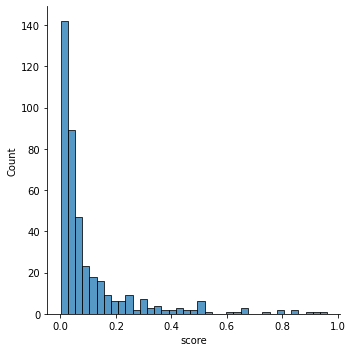

In [303]:
sns.displot(df_recommend[df_recommend['score']<1]['score'])

In [290]:
get_dy_metrics(df_recommend, 'dy_pred_N', 'besst_1', 1)

,top5,top10,top20,top5_besst,top10_besst,top20_besst
dy_mean,0.000527,0.000458,0.000606,0.000030,0.008593,0.005434
pl_mean_last,45.534899,20.663693,27.881437,5.754705,3.608782,-535.294994
cotacao_mean_last,34.223108,18.289428,17.692288,13.022105,39.254138,26.930164


In [291]:
get_dy_metrics(df_recommend, 'dy_pred_S', 'besst_1', 1)

,top5,top10,top20,top5_besst,top10_besst,top20_besst
dy_mean,0.000390,0.000200,0.000316,0.000793,0.003467,0.006265
pl_mean_last,78.592542,45.383646,96.175387,375.870701,190.634370,28.935587
cotacao_mean_last,3.330993,4.564679,5.487364,8.992739,15.189313,22.822770


In [292]:
df_recommend[df_recommend['besst_1']==1].iloc[:20]

,Empresa,Papel,Papel_root,besst_1,dy_label,pl_mean_last,cotacao_mean_last,dy_pred_N,dy_pred_S,dy_pred_N_FS,dy_pred_S_FS,dy_pred_N_FS_LGBM,dy_pred_S_FS_LGBM,score
8770,BANCO MERCANTIL DE INVESTIMENTOS SA ON,BMIN3,BMIN,1.0,0.067590,25.274933,20.901453,-0.759897,-0.279980,82.969685,-0.032572,-30.522439,0.031145,2.656939
22287,COMPANHIA DE SEGUROS ALIANÇA DA BAHIA ON,CSAB3,CSAB,1.0,0.039326,52.537032,61.940998,0.354277,-0.063198,64.700520,-0.056323,-23.557650,0.032369,2.428793
11276,CONSORCIO ALFA PNA,BRGE5,BRGE,1.0,0.000000,33.709897,9.609396,172.735564,69.920493,3.979692,-0.023446,0.792851,0.017284,0.732756
16022,CEB - COMPANHIA ENERGÉTICA DE BRASÍLIA PNA,CEBR5,CEBR,1.0,0.236528,1.067315,14.443704,1.521311,6.299068,3.162517,16.563801,-7.500894,10.466093,4.139876
80519,CEEE ON N1,EEEL3,EEEL,1.0,0.125370,14.515980,407.827790,-21.079663,1.930914,2.658401,-0.800735,0.768991,0.054701,0.517941
30342,EMAE PN,EMAE4,EMAE,1.0,0.278449,7.246631,36.501051,0.024253,24.217549,1.517338,-10.054643,-1.355035,16.213358,2.296114
84754,BBSEGURIDADE ON NM,BBSE3,BBSE,1.0,0.091351,8.390291,24.214831,0.020359,0.002261,1.233072,-0.084921,-0.247172,0.123338,0.229189
86735,AES TIETE E PN N2,TIET4,TIET,1.0,0.038668,6.630114,3.415507,43.694807,54.915933,1.170421,0.014586,-1.357101,0.023871,0.215916
8233,BANCO MERCANTIL DO BRASIL S/A ON,BMEB3,BMEB,1.0,0.012832,7.547568,16.450384,129.991554,166.160866,1.052761,-0.014868,0.130834,0.017564,0.277609
76469,BRB ON,BSLI3,BSLI,1.0,0.068689,12.891027,23.262474,-0.641628,-0.032425,0.686396,0.047409,2.161298,0.068798,0.513310


In [293]:
path = '../data/03_models/out/'
model_name = '2023-08-05_LGBMRegressor_Normalizer()_feat_selection.pkl'

with open(path + model_name, 'rb') as file:
        lgb_regressor = pickle.load(file)

df_to_pred['dy_pred'] = lgb_regressor.predict(X_to_pred[cols_to_train])

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- c5y_mean_trend
- patrliq_mean_trend
- pebit_mean_mean
- pib_dolarizado_trend
- power_stabil
- ...
Feature names seen at fit time, yet now missing:
- cotacao_mean_mean
- cotacao_mean_ref_std
- dy_mean_std
- dy_spread
- evebit_mean_mean
- ...



ValueError: X has 26 features, but Normalizer is expecting 29 features as input.

In [ ]:
df_to_pred[df_to_pred['besst_1']==1].sort_values(by='dy_pred', ascending=False).iloc[0:50][['Empresa','dy_label','dy_pred']]

In [ ]:
path = '../data/03_models/out/'

model_name = f'{date.today()}_LGBMRegressor_Normalizer().pkl'

lgb_model = load_model(path, model_name)

xgb_feature_importance = get_feature_importances(xgb_model, 'XGB', X.columns.to_list())

In [ ]:
print(len(cols_to_train_lgmb))

48


In [ ]:
X.columns.to_list()

['dy_mean_last',
 'dy_median_last',
 'dy_median_max',
 'dy_spread',
 'dy_median_min',
 'dy_median_ref_min',
 'dy_mean_std',
 'power_min',
 'roe_mean_trend',
 'besst_1',
 'Tipo_PN',
 'Tipo_ON',
 'power_buy_flag',
 'power_stabil_delta',
 'dolar_comercial_trend',
 'cotacao_mean_mean',
 'encoded_sectors',
 'cotacao_mean_ref_mean',
 'besst_2',
 'cotacao_max_ref_max',
 'power_stabil',
 'year_last',
 'roe_mean_last',
 'cotacao_mean_last',
 'patrliq_mean_mean',
 'patrliq_mean_last',
 'liq2m_mean_mean',
 'dolar_comercial_last',
 'liqc_mean_mean',
 'liq2m_mean_last',
 'cotacao_mean_ref_std',
 'liqc_mean_last',
 'selic_last',
 'ibovespa_spread_relevance',
 'ibovespa_spread',
 'dolar_comercial_mean',
 'ipca_mean',
 'pib_dolarizado_mean',
 'preco_do_petroleo_mean',
 'ibovespa_mean',
 'igpm_mean',
 'preco_do_petroleo_trend',
 'pib_dolarizado_trend',
 'ipca_trend',
 'ibovespa_trend',
 'igpm_trend',
 'selic_mean',
 'month_last',
 'divbpatr_mean_mean',
 'euro_mean',
 'c5y_mean_mean',
 'divbpatr_max_ref